# Elastic Modulus Comparison

This notebook compares three different methods for calculating elastic modulus of snow layers:
1. **Bergfeld et al. (2023)** - Power-law based on density
2. **Köchle and Schneebeli (2014)** - Exponential relationships from μ-CT and FE simulations  
3. **Wautier et al. (2015)** - Power-law with ice modulus parameter

All three methods require both **density** and **grain form** as inputs.


In [9]:
# Setup and Imports
%load_ext autoreload
%autoreload 2

import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from uncertainties import ufloat
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Add the src directory to import snowpyt_mechparams
sys.path.append('../src')
from snowpilot_utils import convert_grain_form, parse_sample_pits
from snowpyt_mechparams import density, elastic_modulus


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Parse all snowpit files from the data folder
all_pits = parse_sample_pits('data')


Successfully parsed 50278 files
Failed to parse 0 files


In [11]:
# Calculate densities and elastic modulus values for all layers
layer_info = []

for pit in all_pits:
    for layer in pit.snow_profile.layers:
        layer_dict = {
            'pit_id': pit.core_info.pit_id,
            'hand_hardness': layer.hardness,
            'depth_top': layer.depth_top[0] if layer.depth_top else None,  
            'thickness': layer.thickness[0] if layer.thickness else None,
        }

        # Convert grain form and calculate density
        grain_form = convert_grain_form(layer.grain_form_primary, 'kim_geldsetzer') if layer.grain_form_primary else None
        layer_dict['kim_geldsetzer_grain_form'] = grain_form
        
        # Calculate density if we have valid inputs
        if layer.hardness and grain_form:
            try:
                density_ufloat = density.calculate_density( 
                    method='kim_geldsetzer',
                    hand_hardness=layer.hardness,
                    grain_form=grain_form
                )
                layer_dict['density_kim_geldsetzer'] = density_ufloat.nominal_value
                layer_dict['density_kim_geldsetzer_uncertainty'] = density_ufloat.std_dev
            except Exception:
                layer_dict['density_kim_geldsetzer'] = None
                layer_dict['density_kim_geldsetzer_uncertainty'] = None
        else:
            layer_dict['density_kim_geldsetzer'] = None
            layer_dict['density_kim_geldsetzer_uncertainty'] = None

        layer_info.append(layer_dict)

# Create dataframe
layer_df = pd.DataFrame(layer_info)


# Calculate Elastic Modulus using Three Methods

In [12]:
# Function to calculate elastic modulus for a single row using multiple methods
def calculate_emod_row(row):
    """Calculate elastic modulus for a single row using multiple methods."""
    result = {
        'e_mod_bergfeld': np.nan,
        'e_mod_kochle': np.nan,
        'e_mod_wautier': np.nan
    }
    
    # Skip if no grain form or density data
    if pd.isna(row['kim_geldsetzer_grain_form']) or pd.isna(row['density_kim_geldsetzer']):
        return pd.Series(result)
    
    try:
        # Create density ufloat once
        density_ufloat = ufloat(row['density_kim_geldsetzer'], row['density_kim_geldsetzer_uncertainty'])
        grain_form = row['kim_geldsetzer_grain_form']
        
        # Calculate elastic modulus using Bergfeld method
        try:
            E_mod_bergfeld = elastic_modulus.calculate_elastic_modulus(
                method='bergfeld',
                density=density_ufloat,
                grain_form=grain_form
            )
            result['e_mod_bergfeld'] = E_mod_bergfeld.nominal_value
        except Exception:
            pass
        
        # Calculate elastic modulus using Kochle method
        try:
            E_mod_kochle = elastic_modulus.calculate_elastic_modulus(
                method='kochle',
                density=density_ufloat,
                grain_form=grain_form
            )
            result['e_mod_kochle'] = E_mod_kochle.nominal_value
        except Exception:
            pass
        
        # Calculate elastic modulus using Wautier method
        try:
            E_mod_wautier = elastic_modulus.calculate_elastic_modulus(
                method='wautier',
                density=density_ufloat,
                grain_form=grain_form
            )
            result['e_mod_wautier'] = E_mod_wautier.nominal_value
        except Exception:
            pass
        
    except Exception:
        pass
    
    return pd.Series(result)

# Apply the function to all rows at once
layer_df[['e_mod_bergfeld', 'e_mod_kochle', 'e_mod_wautier']] = layer_df.apply(calculate_emod_row, axis=1)


/Users/marykateconnelly/Desktop/F25/SnowPyt-MechParams/venv/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


# Analysis: Success Rates and Grain Form Compatibility


In [13]:
# Calculate success rates
total_layers = len(layer_df)
layers_with_data = layer_df[
    layer_df['density_kim_geldsetzer'].notna() & 
    layer_df['kim_geldsetzer_grain_form'].notna()
].shape[0]

bergfeld_success = layer_df['e_mod_bergfeld'].notna().sum()
kochle_success = layer_df['e_mod_kochle'].notna().sum()
wautier_success = layer_df['e_mod_wautier'].notna().sum()

print("="*70)
print("SUCCESS RATE ANALYSIS")
print("="*70)
print(f"\nTotal layers: {total_layers:,}")
print(f"Layers with both density and grain form: {layers_with_data:,}")
print(f"\n{'Method':<15} {'Successful':<12} {'% of Total':<12} {'% of Available':<15}")
print("-"*70)
print(f"{'Bergfeld':<15} {bergfeld_success:<12,} {100*bergfeld_success/total_layers:>10.2f}% {100*bergfeld_success/layers_with_data:>13.2f}%")
print(f"{'Köchle':<15} {kochle_success:<12,} {100*kochle_success/total_layers:>10.2f}% {100*kochle_success/layers_with_data:>13.2f}%")
print(f"{'Wautier':<15} {wautier_success:<12,} {100*wautier_success/total_layers:>10.2f}% {100*wautier_success/layers_with_data:>13.2f}%")

# Overlaps
all_three = layer_df[
    layer_df['e_mod_bergfeld'].notna() & 
    layer_df['e_mod_kochle'].notna() & 
    layer_df['e_mod_wautier'].notna()
].shape[0]

any_two = layer_df[
    (layer_df['e_mod_bergfeld'].notna() & layer_df['e_mod_kochle'].notna()) |
    (layer_df['e_mod_bergfeld'].notna() & layer_df['e_mod_wautier'].notna()) |
    (layer_df['e_mod_kochle'].notna() & layer_df['e_mod_wautier'].notna())
].shape[0]

any_one = layer_df[
    layer_df['e_mod_bergfeld'].notna() | 
    layer_df['e_mod_kochle'].notna() | 
    layer_df['e_mod_wautier'].notna()
].shape[0]

print(f"\n{'Overlap Analysis':<40} {'Count':<12} {'% of Total'}")
print("-"*70)
print(f"{'At least one method succeeded':<40} {any_one:<12,} {100*any_one/total_layers:>10.2f}%")
print(f"{'At least two methods succeeded':<40} {any_two:<12,} {100*any_two/total_layers:>10.2f}%")
print(f"{'All three methods succeeded':<40} {all_three:<12,} {100*all_three/total_layers:>10.2f}%")

# Grain form compatibility
print("\n" + "="*70)
print("GRAIN FORM COMPATIBILITY BY METHOD")
print("="*70)

bergfeld_grain_forms = ['PP', 'RG', 'DF']
kochle_grain_forms = ['RG', 'RC', 'DH', 'MF']
wautier_grain_forms = ['DF', 'RG', 'FC', 'DH', 'MF']

print("\nSupported grain forms:")
print(f"  Bergfeld: {', '.join(bergfeld_grain_forms)}")
print(f"  Köchle:   {', '.join(kochle_grain_forms)}")
print(f"  Wautier:  {', '.join(wautier_grain_forms)}")

# Analyze grain form distribution in data with density
data_subset = layer_df[layer_df['density_kim_geldsetzer'].notna()].copy()
data_subset['grain_form_main'] = data_subset['kim_geldsetzer_grain_form'].str[:2]
grain_form_counts = data_subset['grain_form_main'].value_counts()

print(f"\n{'Grain Form':<12} {'Count':<12} {'Bergfeld':<12} {'Köchle':<12} {'Wautier':<12}")
print("-"*70)

for gf in grain_form_counts.index:
    if pd.notna(gf):
        count = grain_form_counts[gf]
        b_check = '✓' if gf in bergfeld_grain_forms else '✗'
        k_check = '✓' if gf in kochle_grain_forms else '✗'
        w_check = '✓' if gf in wautier_grain_forms else '✗'
        print(f"{gf:<12} {count:<12,} {b_check:^12} {k_check:^12} {w_check:^12}")


SUCCESS RATE ANALYSIS

Total layers: 371,429
Layers with both density and grain form: 235,522

Method          Successful   % of Total   % of Available 
----------------------------------------------------------------------
Bergfeld        88,319            23.78%         37.50%
Köchle          101,079           27.21%         42.92%
Wautier         203,401           54.76%         86.36%

Overlap Analysis                         Count        % of Total
----------------------------------------------------------------------
At least one method succeeded            207,528           55.87%
At least two methods succeeded           130,427           35.11%
All three methods succeeded              54,844            14.77%

GRAIN FORM COMPATIBILITY BY METHOD

Supported grain forms:
  Bergfeld: PP, RG, DF
  Köchle:   RG, RC, DH, MF
  Wautier:  DF, RG, FC, DH, MF

Grain Form   Count        Bergfeld     Köchle       Wautier     
------------------------------------------------------------------

# Visualization: Grain Form Distribution and Success Rates


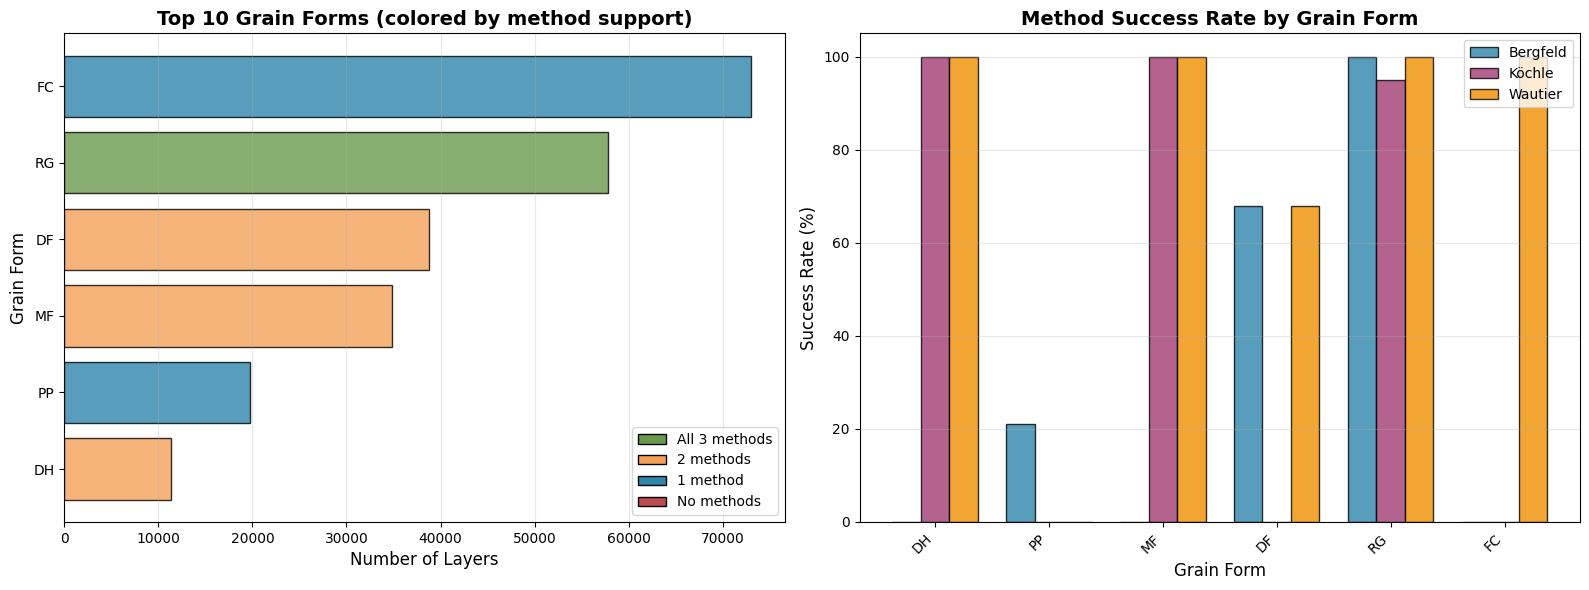

In [14]:
# Visualize grain form distribution and method success rates
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Grain form distribution with method compatibility
grain_form_sorted = grain_form_counts.sort_values(ascending=True).tail(10)

# Create color mapping based on how many methods support each grain form
colors_list = []
for gf in grain_form_sorted.index:
    if pd.notna(gf):
        support_count = sum([
            gf in bergfeld_grain_forms,
            gf in kochle_grain_forms,
            gf in wautier_grain_forms
        ])
        if support_count == 3:
            colors_list.append('#6A994E')  # Green - all 3
        elif support_count == 2:
            colors_list.append('#F4A259')  # Orange - 2 methods
        elif support_count == 1:
            colors_list.append('#2E86AB')  # Blue - 1 method
        else:
            colors_list.append('#BC4B51')  # Red - no methods
    else:
        colors_list.append('#999999')

axes[0].barh(range(len(grain_form_sorted)), grain_form_sorted.values, 
             color=colors_list, alpha=0.8, edgecolor='black')
axes[0].set_yticks(range(len(grain_form_sorted)))
axes[0].set_yticklabels(grain_form_sorted.index)
axes[0].set_xlabel('Number of Layers', fontsize=12)
axes[0].set_ylabel('Grain Form', fontsize=12)
axes[0].set_title('Top 10 Grain Forms (colored by method support)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#6A994E', edgecolor='black', label='All 3 methods'),
    Patch(facecolor='#F4A259', edgecolor='black', label='2 methods'),
    Patch(facecolor='#2E86AB', edgecolor='black', label='1 method'),
    Patch(facecolor='#BC4B51', edgecolor='black', label='No methods')
]
axes[0].legend(handles=legend_elements, loc='lower right')

# Plot 2: Method coverage by grain form
coverage_data = []
for gf in grain_form_sorted.index:
    if pd.notna(gf):
        gf_data = data_subset[data_subset['grain_form_main'] == gf]
        coverage_data.append({
            'grain_form': gf,
            'bergfeld': (gf_data['e_mod_bergfeld'].notna().sum() / len(gf_data) * 100) if len(gf_data) > 0 else 0,
            'kochle': (gf_data['e_mod_kochle'].notna().sum() / len(gf_data) * 100) if len(gf_data) > 0 else 0,
            'wautier': (gf_data['e_mod_wautier'].notna().sum() / len(gf_data) * 100) if len(gf_data) > 0 else 0
        })

coverage_df = pd.DataFrame(coverage_data)
x = np.arange(len(coverage_df))
width = 0.25

axes[1].bar(x - width, coverage_df['bergfeld'], width, label='Bergfeld', color='#2E86AB', alpha=0.8, edgecolor='black')
axes[1].bar(x, coverage_df['kochle'], width, label='Köchle', color='#A23B72', alpha=0.8, edgecolor='black')
axes[1].bar(x + width, coverage_df['wautier'], width, label='Wautier', color='#F18F01', alpha=0.8, edgecolor='black')

axes[1].set_xlabel('Grain Form', fontsize=12)
axes[1].set_ylabel('Success Rate (%)', fontsize=12)
axes[1].set_title('Method Success Rate by Grain Form', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(coverage_df['grain_form'], rotation=45, ha='right')
axes[1].set_ylim(0, 105)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# Theoretical Density vs Elastic Modulus Relationships


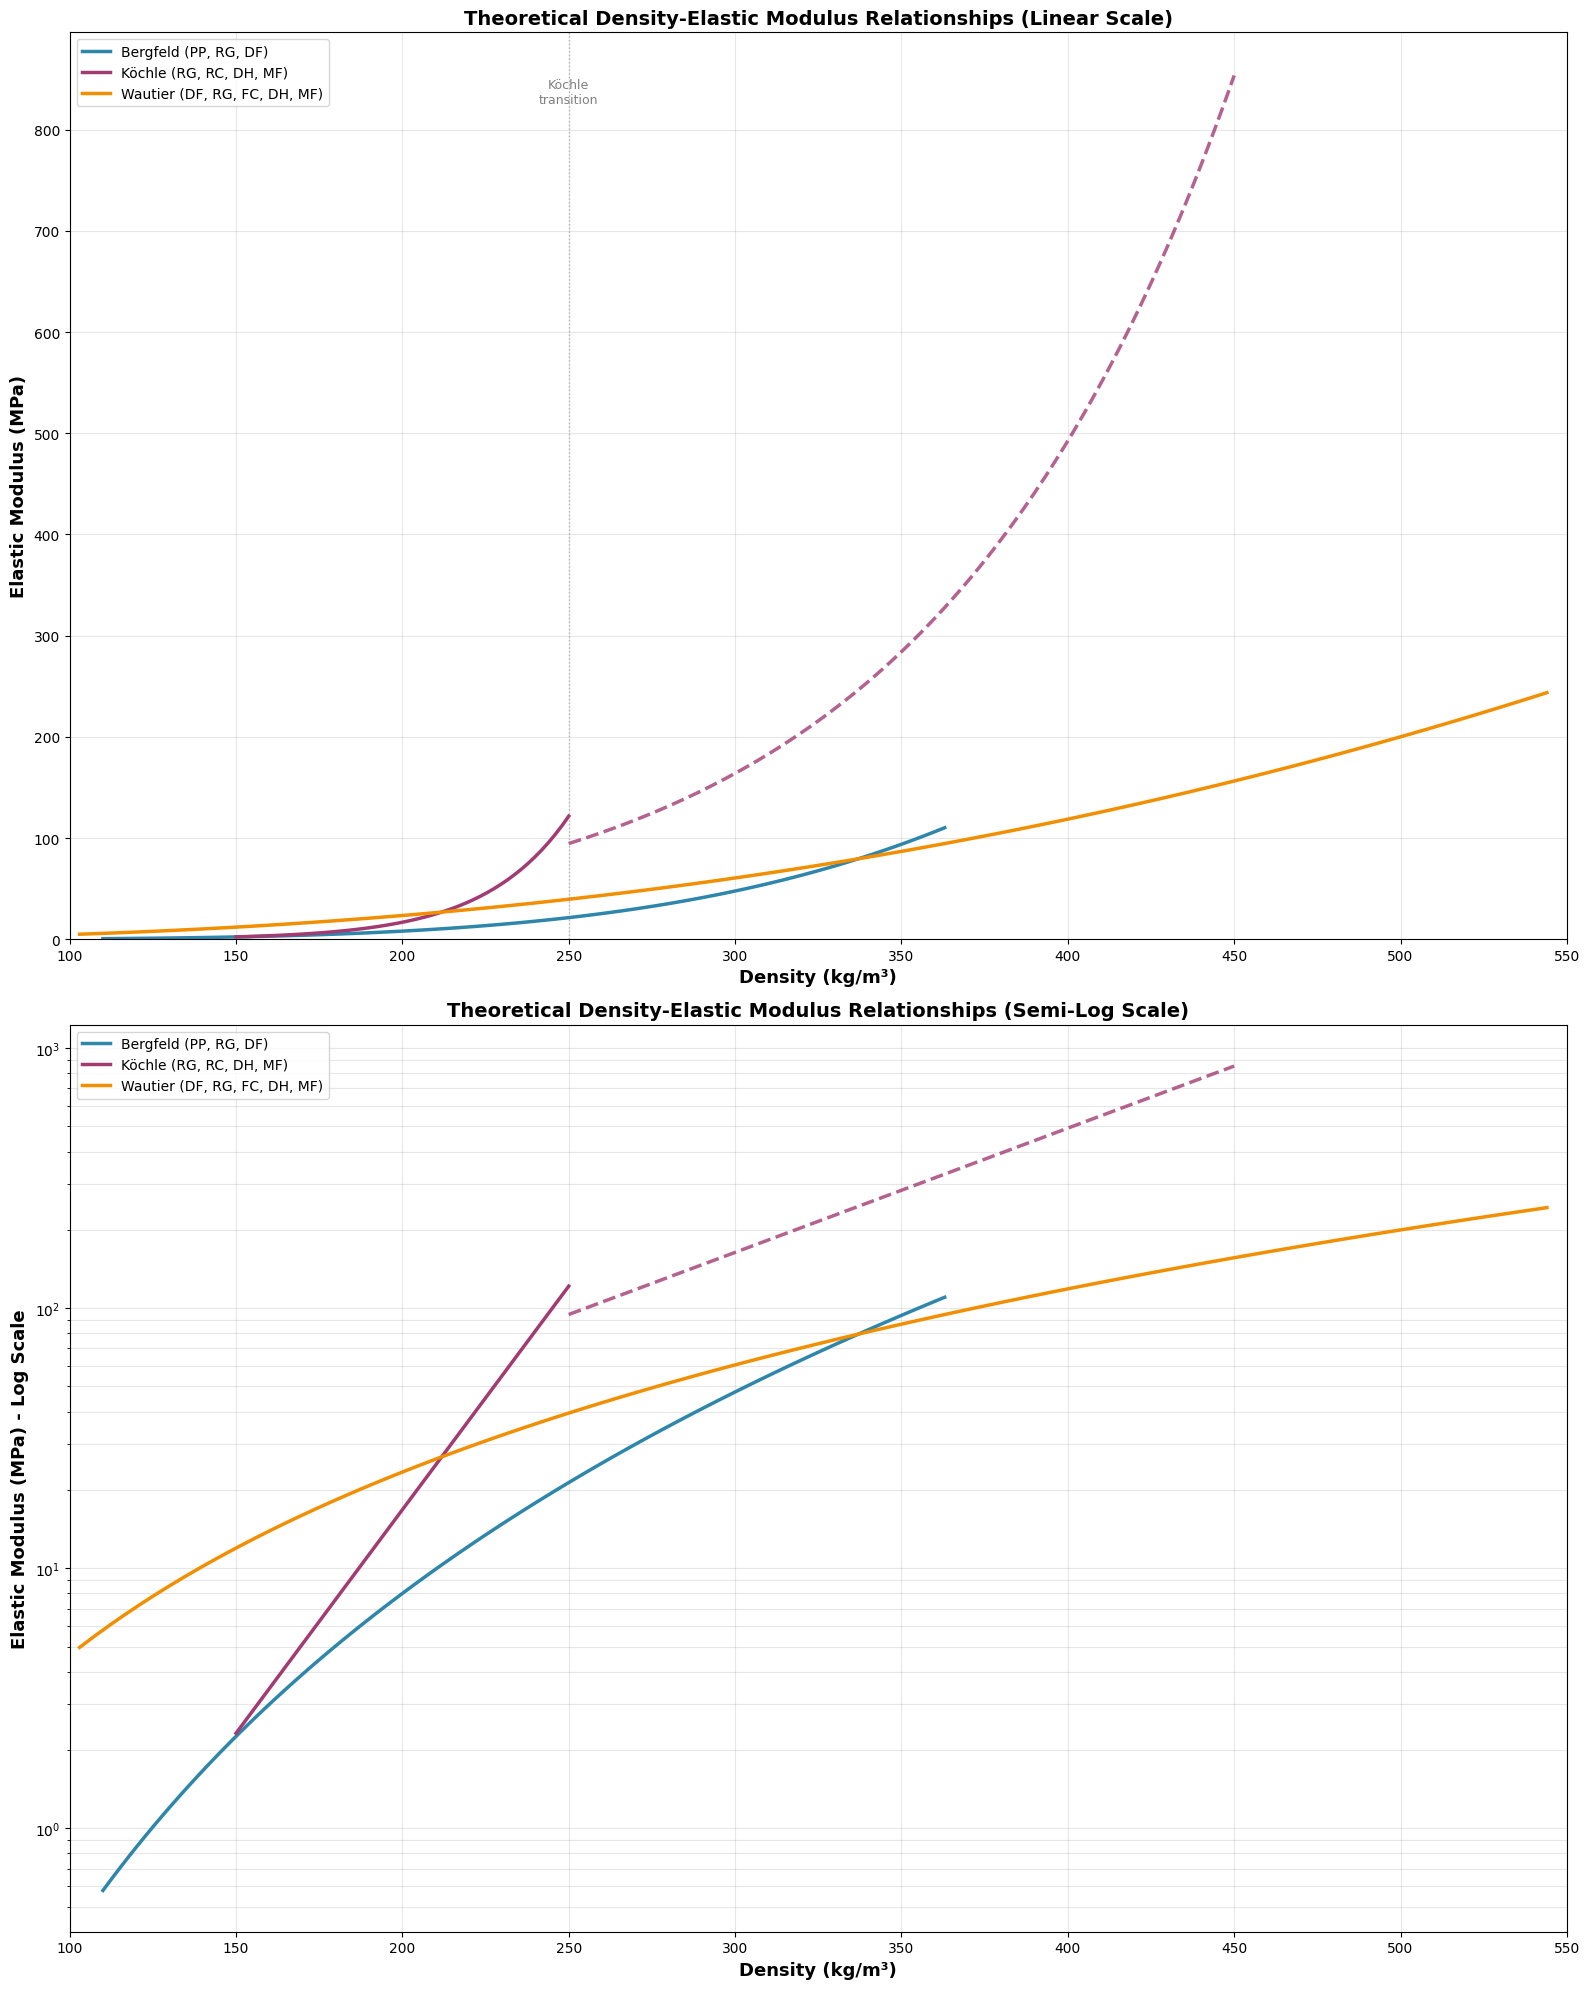


Key Observations:
----------------------------------------------------------------------
• Bergfeld: Power-law (E ∝ ρ^4.4), restricted to lower densities
• Köchle: Two-regime exponential, transitions at ρ=250 kg/m³
• Wautier: Power-law (E ∝ ρ^2.34), widest density range and most grain forms
• Methods diverge significantly at higher densities


In [17]:
# Define theoretical relationships and plot
# Bergfeld: E = 6500 * (ρ / ρ_ice)^4.4
bergfeld_rho = np.linspace(110, 363, 100)
rho_ice = 917.0
bergfeld_E = 6500 * (bergfeld_rho / rho_ice) ** 4.4

# Köchle: Two-regime exponential
kochle_rho_low = np.linspace(150, 250, 50)
kochle_E_low = 0.0061 * np.exp(0.0396 * kochle_rho_low)
kochle_rho_high = np.linspace(250, 450, 100)
kochle_E_high = 6.0457 * np.exp(0.011 * kochle_rho_high)

# Wautier: E_snow = 0.78 * (ρ_snow / ρ_ice)^2.34 * 1060
wautier_rho = np.linspace(103, 544, 100)
wautier_E = 0.78 * (wautier_rho / rho_ice) ** 2.34 * 1060

# Plot on linear and log-log scales
fig, axes = plt.subplots(2, 1, figsize=(16, 20))

for ax in axes:
    ax.plot(bergfeld_rho, bergfeld_E, linewidth=2.5, color='#2E86AB', 
            label='Bergfeld (PP, RG, DF)', linestyle='-')
    ax.plot(kochle_rho_low, kochle_E_low, linewidth=2.5, color='#A23B72', linestyle='-')
    ax.plot(kochle_rho_high, kochle_E_high, linewidth=2.5, color='#A23B72', 
            linestyle='--', alpha=0.8, label='_nolegend_')
    ax.plot([], [], linewidth=2.5, color='#A23B72', linestyle='-',
            label='Köchle (RG, RC, DH, MF)')
    ax.plot(wautier_rho, wautier_E, linewidth=2.5, color='#F18F01', 
            label='Wautier (DF, RG, FC, DH, MF)', linestyle='-')
    ax.set_xlabel('Density (kg/m³)', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(alpha=0.3, which='both' if ax == axes[1] else 'major')
    ax.set_xlim(100, 550)

axes[0].set_ylabel('Elastic Modulus (MPa)', fontsize=13, fontweight='bold')
axes[0].set_title('Theoretical Density-Elastic Modulus Relationships (Linear Scale)', 
                  fontsize=14, fontweight='bold')
axes[0].axvline(250, color='gray', linestyle=':', alpha=0.5, linewidth=1)
axes[0].text(250, axes[0].get_ylim()[1]*0.95, 'Köchle\ntransition', 
             ha='center', va='top', fontsize=9, color='gray')
axes[0].set_ylim(0, axes[0].get_ylim()[1])

axes[1].set_ylabel('Elastic Modulus (MPa) - Log Scale', fontsize=13, fontweight='bold')
axes[1].set_title('Theoretical Density-Elastic Modulus Relationships (Semi-Log Scale)', 
                  fontsize=14, fontweight='bold')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("-"*70)
print("• Bergfeld: Power-law (E ∝ ρ^4.4), restricted to lower densities")
print("• Köchle: Two-regime exponential, transitions at ρ=250 kg/m³")
print("• Wautier: Power-law (E ∝ ρ^2.34), widest density range and most grain forms")
print("• Methods diverge significantly at higher densities")


# Layer-by-Layer Comparison

This visualization shows elastic modulus values calculated by each method for the same snow layers. Vertical bars connect results from different methods for identical layers, revealing systematic differences between methods.


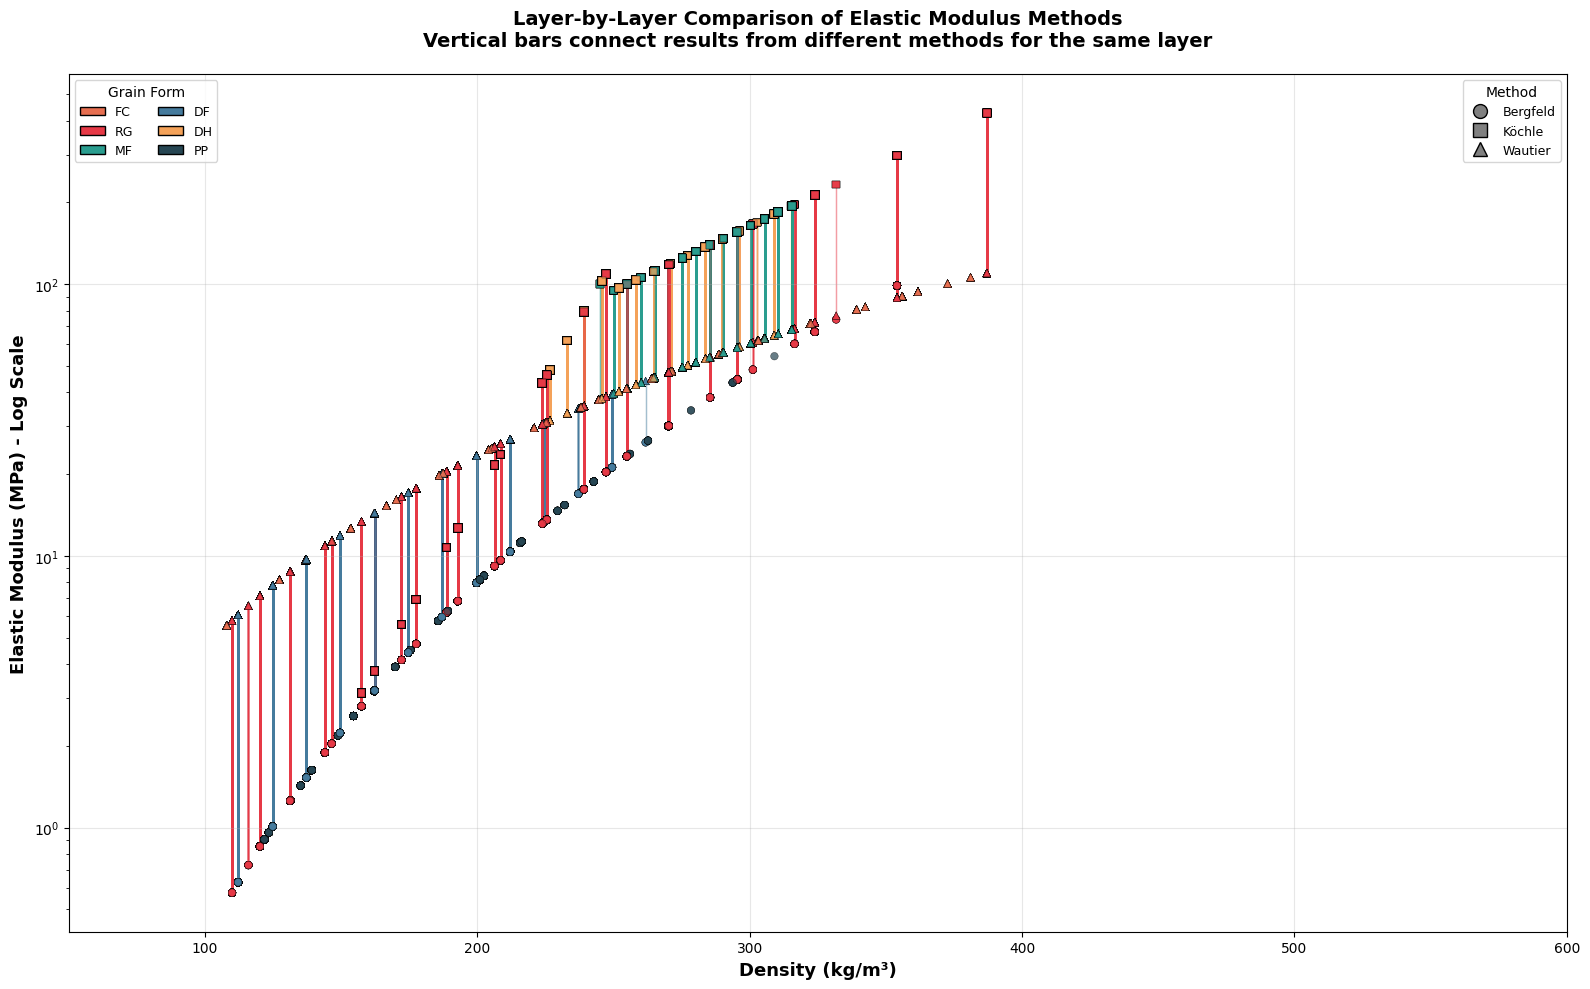


Plotted 392,799 data points
• Marker SHAPE: ○ Bergfeld, □ Köchle, △ Wautier
• Marker COLOR: Grain form
• Vertical bars: Connect results from different methods for the same layer


In [16]:
# Prepare data for visualization
plot_df = layer_df[
    layer_df['e_mod_bergfeld'].notna() | 
    layer_df['e_mod_kochle'].notna() | 
    layer_df['e_mod_wautier'].notna()
].copy()

plot_df['grain_form_main'] = plot_df['kim_geldsetzer_grain_form'].str[:2]

# Define color palette
grain_form_colors = {
    'RG': '#E63946', 'DF': '#457B9D', 'DH': '#F4A259', 'MF': '#2A9D8F',
    'FC': '#E76F51', 'PP': '#264653', 'RC': '#BC4B51', 'SH': '#8D5B4C'
}

# Collect data for scatter plot efficiently
bergfeld_densities, bergfeld_values, bergfeld_colors = [], [], []
kochle_densities, kochle_values, kochle_colors = [], [], []
wautier_densities, wautier_values, wautier_colors = [], [], []
bar_data = []

for idx, row in plot_df.iterrows():
    grain_form = row['grain_form_main']
    color = grain_form_colors.get(grain_form, '#999999')
    density = row['density_kim_geldsetzer']
    values = []
    
    if pd.notna(row['e_mod_bergfeld']):
        bergfeld_densities.append(density)
        bergfeld_values.append(row['e_mod_bergfeld'])
        bergfeld_colors.append(color)
        values.append(row['e_mod_bergfeld'])
    
    if pd.notna(row['e_mod_kochle']):
        kochle_densities.append(density)
        kochle_values.append(row['e_mod_kochle'])
        kochle_colors.append(color)
        values.append(row['e_mod_kochle'])
    
    if pd.notna(row['e_mod_wautier']):
        wautier_densities.append(density)
        wautier_values.append(row['e_mod_wautier'])
        wautier_colors.append(color)
        values.append(row['e_mod_wautier'])
    
    # Collect bar data if multiple methods
    if len(values) > 1:
        bar_data.append((density, min(values), max(values), color))

# Create scatter plot
fig, ax = plt.subplots(figsize=(16, 10))

# Plot connecting bars
for density, min_val, max_val, color in bar_data:
    ax.plot([density, density], [min_val, max_val], color=color, 
           alpha=0.2, linewidth=1, zorder=1)

# Plot all points by method
if bergfeld_densities:
    ax.scatter(bergfeld_densities, bergfeld_values, marker='o', s=30, 
              c=bergfeld_colors, edgecolor='black', linewidth=0.3, 
              alpha=0.7, zorder=2, label='_nolegend_')

if kochle_densities:
    ax.scatter(kochle_densities, kochle_values, marker='s', s=30, 
              c=kochle_colors, edgecolor='black', linewidth=0.3, 
              alpha=0.7, zorder=2, label='_nolegend_')

if wautier_densities:
    ax.scatter(wautier_densities, wautier_values, marker='^', s=30, 
              c=wautier_colors, edgecolor='black', linewidth=0.3, 
              alpha=0.7, zorder=2, label='_nolegend_')

# Create legends

top_grain_forms = plot_df['grain_form_main'].value_counts().head(8).index.tolist()
grain_legend_elements = [
    Patch(facecolor=grain_form_colors[gf], edgecolor='black', label=gf)
    for gf in top_grain_forms if gf in grain_form_colors
]

method_legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markeredgecolor='black', markersize=10, label='Bergfeld'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', 
           markeredgecolor='black', markersize=10, label='Köchle'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', 
           markeredgecolor='black', markersize=10, label='Wautier')
]

legend1 = ax.legend(handles=grain_legend_elements, title='Grain Form', 
                   loc='upper left', fontsize=9, title_fontsize=10, ncol=2)
ax.add_artist(legend1)
ax.legend(handles=method_legend_elements, title='Method', 
          loc='upper right', fontsize=9, title_fontsize=10)

ax.set_xlabel('Density (kg/m³)', fontsize=13, fontweight='bold')
ax.set_ylabel('Elastic Modulus (MPa) - Log Scale', fontsize=13, fontweight='bold')
ax.set_title('Layer-by-Layer Comparison of Elastic Modulus Methods\n' + 
             'Vertical bars connect results from different methods for the same layer', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_yscale('log')
ax.grid(alpha=0.3)
ax.set_xlim(50, 600)

plt.tight_layout()
plt.show()

print(f"\nPlotted {len(bergfeld_densities) + len(kochle_densities) + len(wautier_densities):,} data points")
print("• Marker SHAPE: ○ Bergfeld, □ Köchle, △ Wautier")
print("• Marker COLOR: Grain form")
print("• Vertical bars: Connect results from different methods for the same layer")


# Combined Plot: Theoretical Curves with Layer-by-Layer Data

This plot overlays the actual layer-by-layer data points on top of the theoretical curves, allowing direct comparison between the mathematical relationships and real-world measurements.


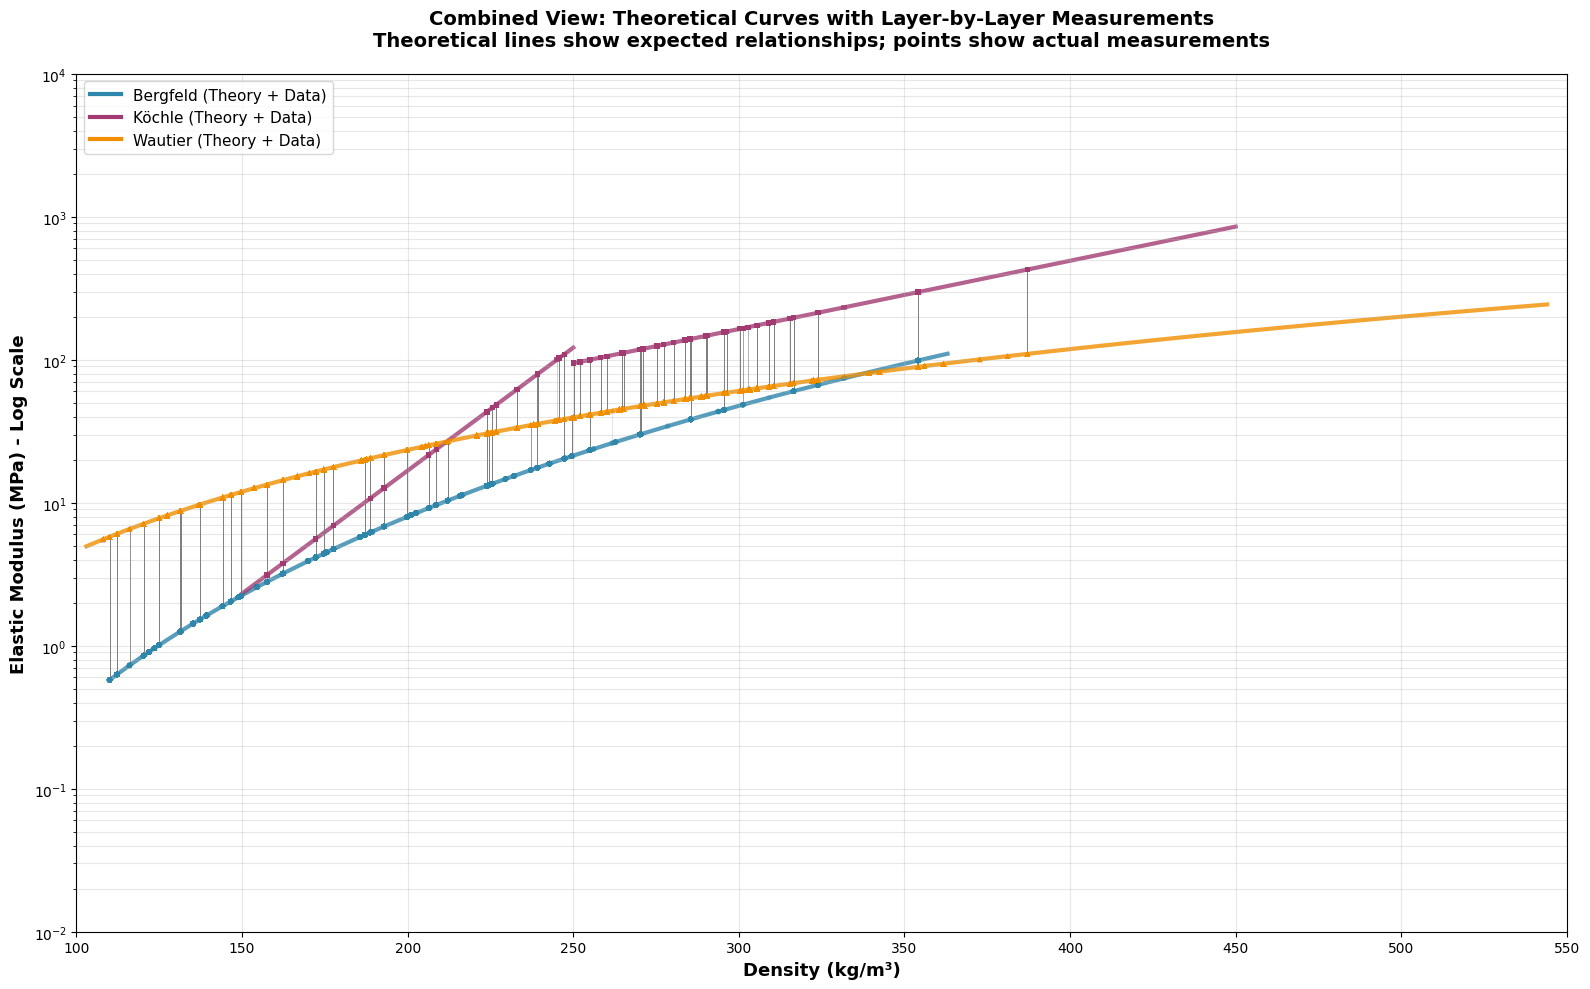


Combined plot shows:
• Theoretical curves (thick lines) - mathematical relationships from literature
• Actual measurements (semi-transparent points) - calculated from snow pit data
• Agreement between theory and data validates the methods


In [ ]:
# Create combined plot with theoretical curves and layer-by-layer data
fig, ax = plt.subplots(figsize=(16, 10))

# Plot theoretical curves first (as background)
ax.plot(bergfeld_rho, bergfeld_E, linewidth=3, color='#2E86AB', 
        label='Bergfeld Theory', linestyle='-', alpha=0.8, zorder=1)
ax.plot(kochle_rho_low, kochle_E_low, linewidth=3, color='#A23B72', 
        linestyle='-', alpha=0.8, zorder=1)
ax.plot(kochle_rho_high, kochle_E_high, linewidth=3, color='#A23B72', 
        linestyle='-', alpha=0.8, zorder=1, label='Köchle Theory')
ax.plot(wautier_rho, wautier_E, linewidth=3, color='#F18F01', 
        label='Wautier Theory', linestyle='-', alpha=0.8, zorder=1)

# Plot connecting bars for data points
for density, min_val, max_val, color in bar_data:
    ax.plot([density, density], [min_val, max_val], color='gray', 
           alpha=0.1, linewidth=0.5, zorder=2)

# Plot layer-by-layer data points on top
if bergfeld_densities:
    ax.scatter(bergfeld_densities, bergfeld_values, marker='o', s=15, 
              c='#2E86AB', edgecolor='none', alpha=0.3, zorder=3, label='_nolegend_')

if kochle_densities:
    ax.scatter(kochle_densities, kochle_values, marker='s', s=15, 
              c='#A23B72', edgecolor='none', alpha=0.3, zorder=3, label='_nolegend_')

if wautier_densities:
    ax.scatter(wautier_densities, wautier_values, marker='^', s=15, 
              c='#F18F01', edgecolor='none', alpha=0.3, zorder=3, label='_nolegend_')

# Add method markers to legend
from matplotlib.lines import Line2D
method_legend_elements = [
    Line2D([0], [0], color='#2E86AB', linewidth=3, label='Bergfeld (Theory + Data)'),
    Line2D([0], [0], color='#A23B72', linewidth=3, label='Köchle (Theory + Data)'),
    Line2D([0], [0], color='#F18F01', linewidth=3, label='Wautier (Theory + Data)')
]

ax.legend(handles=method_legend_elements, loc='upper left', fontsize=11, title_fontsize=12)

ax.set_xlabel('Density (kg/m³)', fontsize=13, fontweight='bold')
ax.set_ylabel('Elastic Modulus (MPa) - Log Scale', fontsize=13, fontweight='bold')
ax.set_title('Combined View: Calculated Elastic Modulus Values by Method and grain form\n', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_yscale('log')
ax.grid(alpha=0.3, which='both')
ax.set_xlim(100, 550)
ax.set_ylim(0.01, 10000)

plt.tight_layout()
plt.show()
